# Meteorologie hautnah – Mobile Stadtklimamessungen als Citizen Science-Projekt
*Oscar Ritter und Johannes Röttenbacher*

Inhalt:
- 2 Gruppen getrennt plotten (Zeitreihe, T und delta T zu Holzhausen, Taupunkt)
- Unterschied nach android/Iphone
- Karte mit Temperaturmessungen
- Zeitreihe Holzhausen dazupacken
- Interpolieren der Messwerte auf Gitter 10mx10m 5minuten Mittel (optional sonst komplett Mittel)


In [2]:
%matplotlib inline
# import modules
import os

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wetterdienst import Wetterdienst, Resolution
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset

import meteohautnah.meteohautnah as mh


In [10]:
# define a function to retrieve station data from the DWD network
def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=DwdObservationDataset.TEMPERATURE_AIR,
                                    resolution=Resolution.MINUTE_10,
                                    start_date=start_date,
                                    end_date=end_date,
                                    ).filter_by_name(name=name)

    df = request.values.all().df
    df = df.to_pandas()
    df_t = df[df['parameter'] == "temperature_air_mean_200"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_t.rename(columns={'value': 'air_temperature'}, inplace=True)
    df_dew = df[df.parameter == "temperature_dew_point_mean_200"].drop(
        ['station_id', 'dataset', 'parameter', 'quality'], axis=1)

    df_dew.rename(columns={'value': 'dewpoint'}, inplace=True)

    df_t.set_index(pd.DatetimeIndex(df_t['date']), inplace=True)
    df_dew.set_index(pd.DatetimeIndex(df_t['date']), inplace=True)

    df_out = df_t.merge(df_dew, how='left', left_index=True, right_index=True)
    df_out["time"] = pd.to_datetime(df_t.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    df_out = df_out.drop(["date_x", "date_y"], axis=1)
    df_out['air_temperature'] = df_out['air_temperature'] - 273.15
    df_out['dewpoint'] = df_out['dewpoint'] - 273.15

    return df_out


In [11]:
# set paths
base_path = 'C:/Users/Johannes/Documents/MeteorologieHautnah/MeteorologieHautnah'
data_path = f'{base_path}/Daten/processed'
plot_path = f'{base_path}/Daten/plots/stumeta'
os.makedirs(plot_path, exist_ok=True)

In [12]:
group1 = ['04']
group2 = ['10']

In [13]:
# read in and filter data
device_ids = pd.read_csv(f'{base_path}/Daten/device_ids.txt',
                         skipinitialspace=True,
                         )
g1 = device_ids['MAC-address'][device_ids["number"].isin(group1)]
g2 = device_ids['MAC-address'][device_ids["number"].isin(group2)]
device_ids.rename(columns={'MAC-address': 'device_id',
                           'number': 'Nummer'},
                  inplace=True)

In [14]:
df = mh.read_data(data_path,
                  date='2024-05-05',
                  speedfilter=10)
df['Gruppe'] = np.where(df['device_id'].isin(g1), 1, 2)
df = df.merge(device_ids, on='device_id', how='left')

## Zeitreihen der beiden Gruppen
### Lufttemperatur

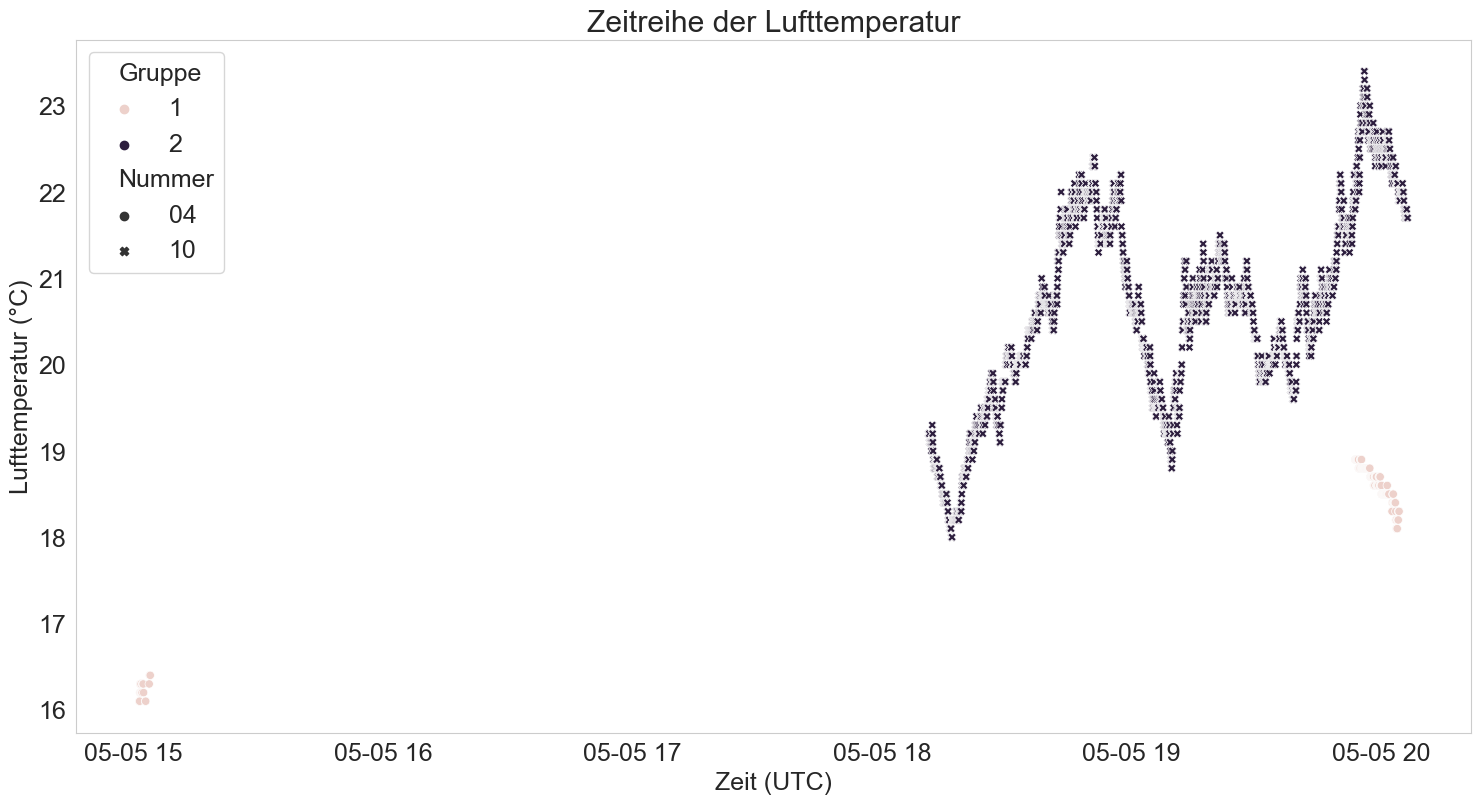

In [15]:
plt.rc('font', size=18)
_, ax = plt.subplots(figsize=(18, 9))
sns.scatterplot(data=df, x='time', y='air_temperature', ax=ax,
                hue='Gruppe', style='Nummer')
ax.set(
    title='Zeitreihe der Lufttemperatur',
    xlabel='Zeit (UTC)',
    ylabel='Lufttemperatur (°C)',
)
ax.grid()
plt.show()


### Taupunkt

C:\Users\Johannes\AppData\Local\Temp\ipykernel_24820\1936132604.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df, x='time', y='dewpoint', ax=ax,
C:\Users\Johannes\AppData\Local\Temp\ipykernel_24820\1936132604.py:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df, x='time', y='air_temperature', ax=ax,


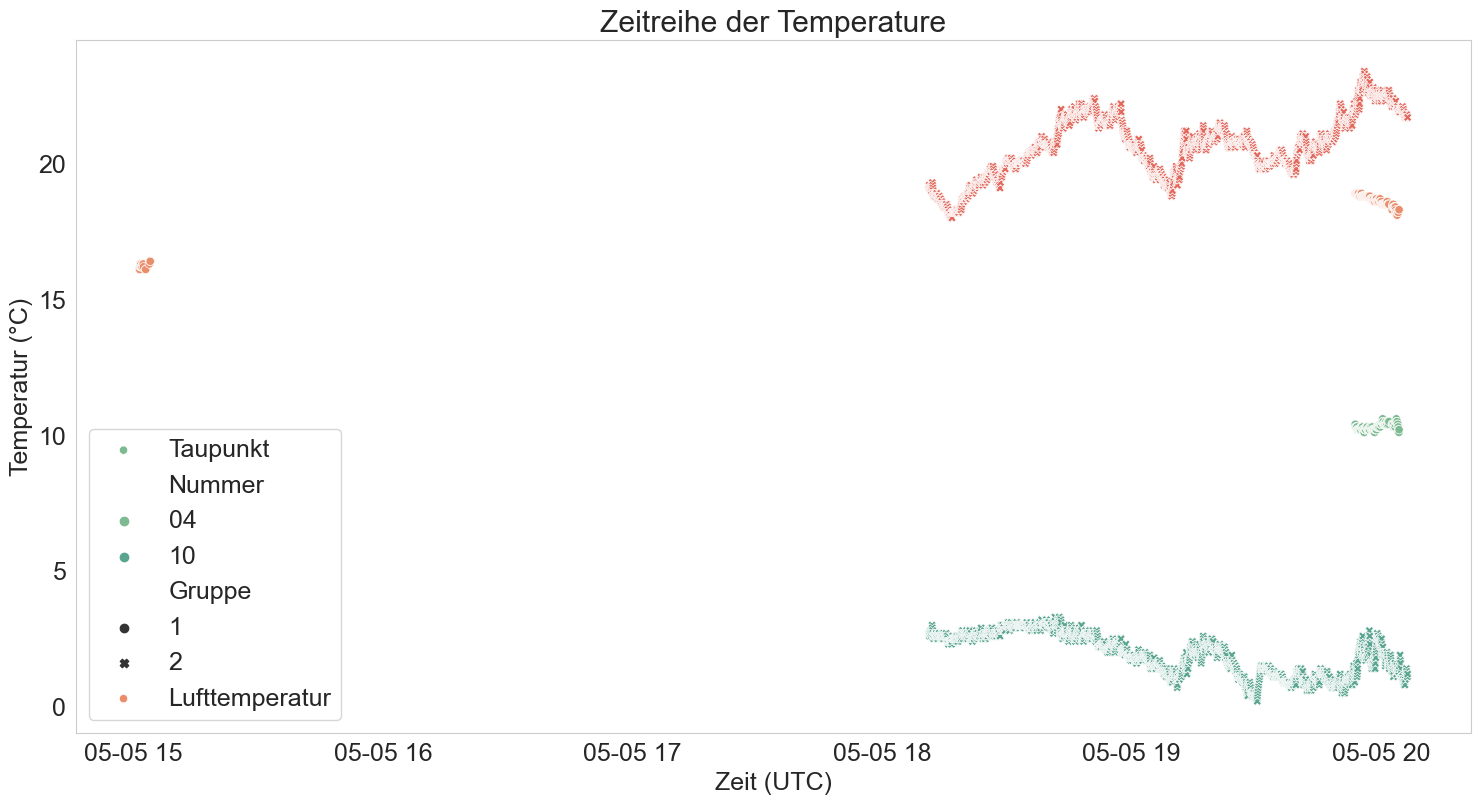

In [16]:
plt.rc('font', size=18)
_, ax = plt.subplots(figsize=(18, 9))
sns.scatterplot(data=df, x='time', y='dewpoint', ax=ax,
                hue='Nummer', style='Gruppe', palette=sns.color_palette('crest'),
                label='Taupunkt')
sns.scatterplot(data=df, x='time', y='air_temperature', ax=ax,
                hue='Gruppe', style='Nummer', label='Lufttemperatur', legend=False,
                palette=sns.color_palette('flare'))
ax.set(
    title='Zeitreihe der Temperature',
    xlabel='Zeit (UTC)',
    ylabel='Temperatur (°C)',
)
ax.legend()
ax.grid()
plt.show()

## Karte mit Messpunkten

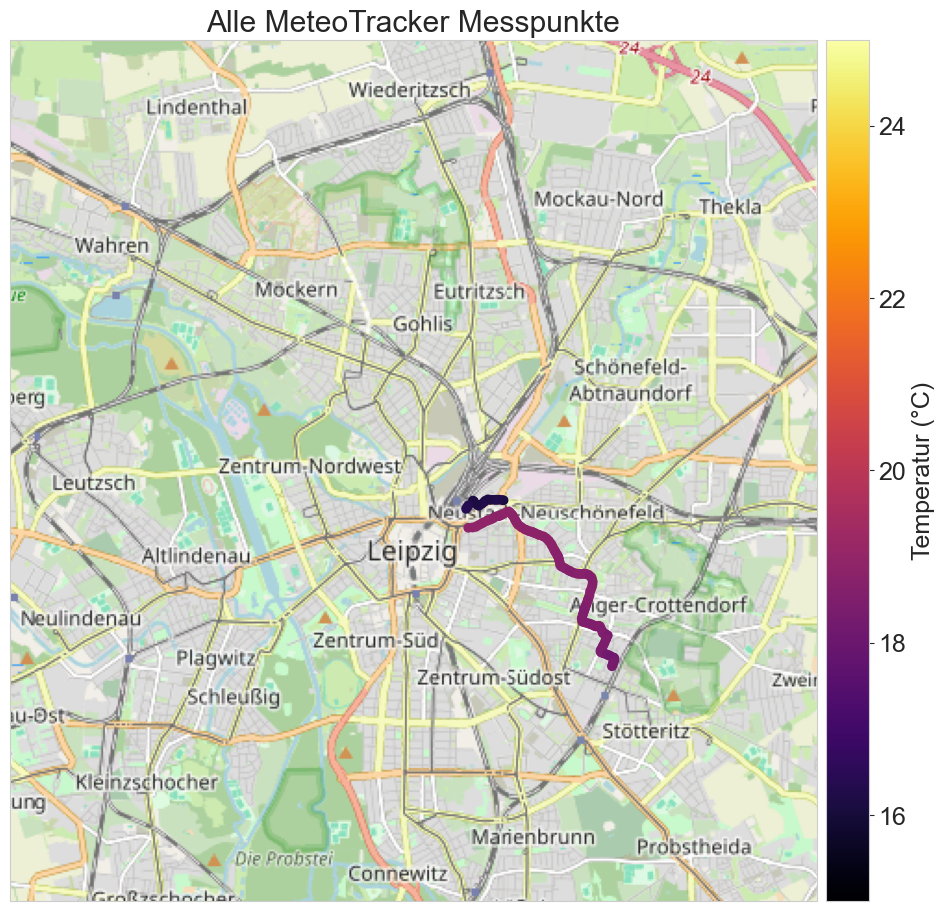

In [17]:
plot_df1 = df[df['Gruppe'] == 1]
plot_df2 = df[df['Gruppe'] == 2]
request = cimgt.OSM()
_, ax = plt.subplots(figsize=(10, 9),
                     subplot_kw=dict(projection=request.crs),
                     layout='constrained')
# extent = [12.2, 12.55, 51.16, 51.45]  # (xmin, xmax, ymin, ymax)
extent = [12.3, 12.45, 51.30, 51.4]  # (xmin, xmax, ymin, ymax)
ax.set_extent(extent)
ax.add_image(request, 12)
scatter = ax.scatter(plot_df1['lon'], plot_df1['lat'],
                     c=plot_df1['air_temperature'],
                     transform=ccrs.Geodetic(),
                     cmap='inferno', vmin=15, vmax=25,
                     marker='o')
ax.scatter(plot_df2['lon'], plot_df2['lat'],
           c=plot_df2['air_temperature'],
           transform=ccrs.Geodetic(),
           cmap='inferno', vmin=15, vmax=25,
           marker='x')
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.01,
                    label='Temperatur (°C)')
ax.set_title('Alle MeteoTracker Messpunkte')
# plt.savefig(f'{plot_path}/alle_messungen_juli.png', dpi=300, transparent=True)
plt.show()


## Vergleich zur DWD Station Holzhausen

In [23]:
df_dwd = station_temp('Leipzig-Holzhausen',
                      '2024-05-05',
                      '2024-05-07')

In [30]:
df_dwd['device_id'] = 'DWD'
df = pd.concat([df, df_dwd])